# Non-Linear Mean Reversion: Extensions to the Ornstein–Uhlenbeck Process

## Motivation

The classical **Ornstein–Uhlenbeck** process models mean reversion as:

$$dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t$$

We work with **standardised deviations** from a rolling mean:

$$X_t = \frac{\log P_t - \mu_t^{(\text{roll})}}{\sigma_t^{(\text{roll})}}$$

so that $X_t$ is a local z-score. Returns are likewise normalised:

$$\Delta X_t = X_t - X_{t-1}$$

and we regress $\Delta X_t$ on functions of $X_{t-1}$.

### Models

| # | Model | Equation | Idea |
|---|---|---|---|
| 1 | **Classic OU** | $\Delta X_t = a + b\,X_t$ | Linear mean reversion |
| 2 | **Tanh** | $\Delta X_t = a + b\,\tanh(\alpha\,X_t)$ | Reversion saturates; $\alpha$ fitted by profile AIC |
| 3 | **Asymmetric** | $\Delta X_t = a + b^+X_t\mathbb{1}_{X>0} + b^-X_t\mathbb{1}_{X\leq 0}$ | Different speed above/below mean |
| 4 | **Asymmetric Tanh** | $\Delta X_t = a + b^+\tanh(\alpha X_t)\mathbb{1}_{X>0} + b^-\tanh(\alpha X_t)\mathbb{1}_{X\leq 0}$ | Both effects combined |

We compare fits across **FX symbols** and **multiple timeframes**.

In [12]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from IPython.display import display, HTML
from tests.test_records import positions

plt.rcParams.update({
    'figure.figsize': (14, 5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

In [13]:
# ---- MT5 connection ----
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")
print(f"MT5 connected  —  build {mt5.version()}")

def pull_close_prices(symbol: str, timeframe: int, num_bars: int = 50_000) -> pd.Series:
    """Pull close prices from MT5 and return as a datetime-indexed Series."""
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
    if rates is None or len(rates) == 0:
        raise ValueError(f"No data returned for {symbol} / tf={timeframe}")
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df['close']

MT5 connected  —  build (500, 5430, '14 Nov 2025')


AUDCHF  |  50,000 bars  |  rolling window = 800
After dropna: 49,201 obs  |  mean(X) = -0.1475  |  std(X) = 1.3980


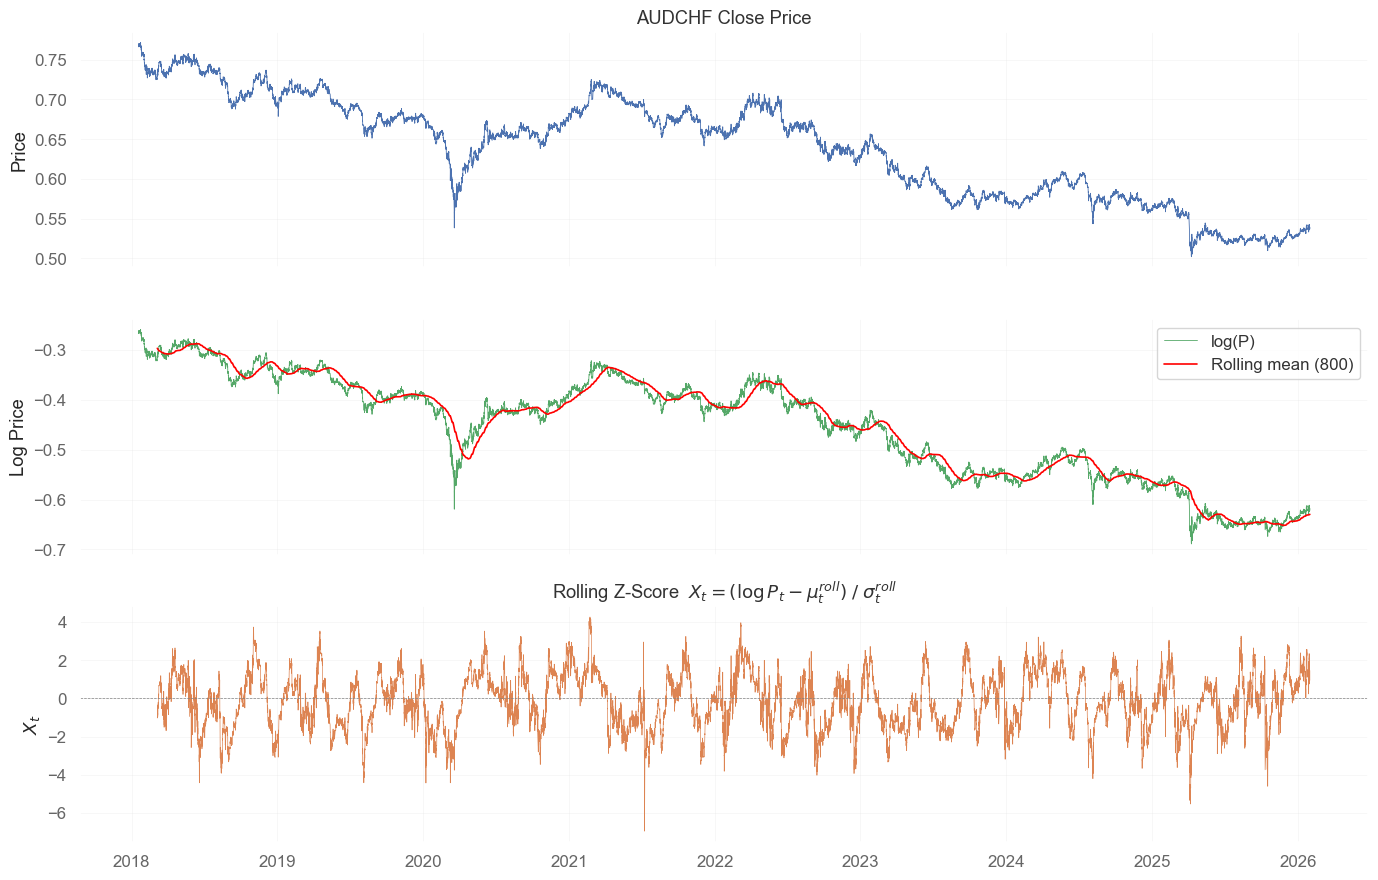

In [99]:
# ---- Configuration ----
SYMBOL         = "AUDCHF"
TIMEFRAME      = mt5.TIMEFRAME_H1
NUM_BARS       = 50_000
ROLLING_WINDOW = 800          # rolling window for mean & std

# ---- Pull & transform ----
close     = pull_close_prices(SYMBOL, TIMEFRAME, NUM_BARS)
log_close = np.log(close)

rolling_mu    = log_close.rolling(ROLLING_WINDOW).mean()
rolling_sigma = log_close.rolling(ROLLING_WINDOW).std()

X = ((log_close - rolling_mu) / rolling_sigma).dropna()   # rolling z-score

print(f"{SYMBOL}  |  {len(close):,} bars  |  rolling window = {ROLLING_WINDOW}")
print(f"After dropna: {len(X):,} obs  |  mean(X) = {X.mean():.4f}  |  std(X) = {X.std():.4f}")

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

axes[0].plot(close.index, close.values, linewidth=0.6)
axes[0].set_title(f"{SYMBOL} Close Price")
axes[0].set_ylabel("Price")

axes[1].plot(log_close.index, log_close.values, linewidth=0.6, color='C2', label='log(P)')
axes[1].plot(rolling_mu.index, rolling_mu.values, linewidth=1.2, color='red', label=f'Rolling mean ({ROLLING_WINDOW})')
axes[1].set_ylabel("Log Price")
axes[1].legend()

axes[2].plot(X.index, X.values, linewidth=0.5, color='C1')
axes[2].axhline(0, color='grey', ls='--', lw=0.5)
axes[2].set_title(r"Rolling Z-Score  $X_t = (\log P_t - \mu_t^{roll}) \;/\; \sigma_t^{roll}$")
axes[2].set_ylabel(r"$X_t$")

plt.tight_layout()
plt.show()

In [36]:
# ---- Prepare regression vectors ----
# dX[t] = X[t] - X[t-1], regressed on X_lag[t] = X[t-1]
dX    = X.diff().dropna()
X_lag = X.shift(1).dropna()          # same index as dX after dropna

print(f"Regression sample: {len(dX):,} obs")
print(f"X_lag  —  mean={X_lag.mean():.4f}   std={X_lag.std():.4f}   "
      f"min={X_lag.min():.2f}   max={X_lag.max():.2f}")

Regression sample: 49,200 obs
X_lag  —  mean=-0.1476   std=1.3980   min=-6.95   max=4.26


---
## 1. Classic OU Regression

$$\Delta X_t = a + b\,X_t + \varepsilon_t$$

- $b < 0$ with a small p-value → mean reversion
- Half-life $= -\ln 2 \,/\, \ln(1+b)$ (in bar units)

In [37]:
model_classic = sm.OLS(dX, sm.add_constant(X_lag)).fit()

print("=" * 70)
print("MODEL 1 — Classic OU :  dX_t  =  a  +  b * X_t  +  eps")
print("=" * 70)
print(model_classic.summary())

b = model_classic.params.iloc[1]
if b < 0:
    hl = -np.log(2) / np.log(1 + b)
    print(f"\n>> Mean-reversion speed  theta = {-b:.6f}")
    print(f">> Half-life             = {hl:.1f} bars")
else:
    print("\n>> b >= 0  -->  no mean reversion detected")

MODEL 1 — Classic OU :  dX_t  =  a  +  b * X_t  +  eps
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     109.8
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           1.17e-25
Time:                        13:19:29   Log-Likelihood:                 29874.
No. Observations:               49200   AIC:                        -5.974e+04
Df Residuals:                   49198   BIC:                        -5.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

---
## 2. Non-Linear Tanh Model

$$\Delta X_t = a + b\,\tanh(\alpha\, X_t) + \varepsilon_t$$

The **scale parameter $\alpha$** controls the degree of non-linearity:
- $\alpha \to 0$: $\tanh(\alpha X) \approx \alpha X$ — recovers the linear model
- $\alpha \approx 1$: moderate non-linearity around $|X| \sim 1$ (one rolling-std move)
- $\alpha \gg 1$: $\tanh(\alpha X) \to \text{sign}(X)$ — pure regime-switch

We find the **optimal $\alpha$** by profiling: for each candidate $\alpha$, run OLS on the remaining linear parameters $(a, b)$ and pick the $\alpha$ that minimises **AIC**.

Optimal alpha = 61.8264   (AIC = 0.00)

MODEL 2 — Tanh :  dX = a + b * tanh(61.826 * X)  +  eps
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.65
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           1.12e-12
Time:                        13:20:36   Log-Likelihood:                 29845.
No. Observations:               49200   AIC:                        -5.969e+04
Df Residuals:                   49198   BIC:                        -5.967e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

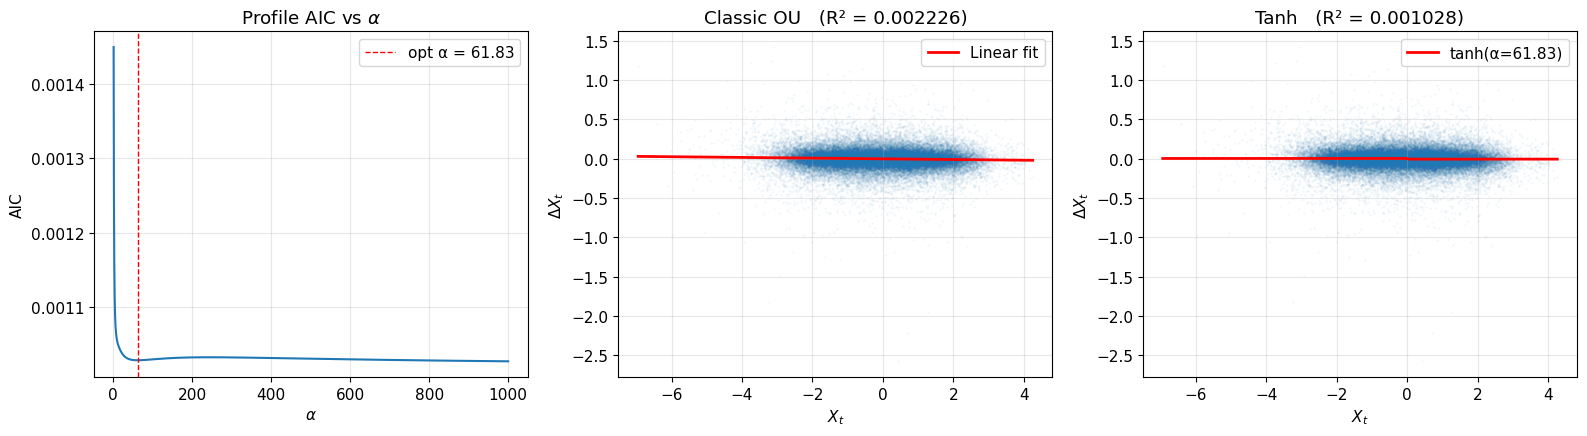

In [40]:
# ---- Profile optimisation: find best alpha ----
def tanh_aic(alpha, dX, X_lag):
    """OLS AIC for dX = a + b*tanh(alpha*X) at a fixed alpha."""
    feat = np.tanh(alpha * X_lag)
    return sm.OLS(dX, sm.add_constant(feat)).fit().rsquared

opt = minimize_scalar(tanh_aic, bounds=(1, 100.0), method='bounded',
                      args=(dX, X_lag))
optimal_alpha = opt.x
print(f"Optimal alpha = {optimal_alpha:.4f}   (AIC = {opt.fun:.2f})")

# ---- Fit final model with optimal alpha ----
tanh_feature = np.tanh(optimal_alpha * X_lag)
model_tanh   = sm.OLS(dX, sm.add_constant(tanh_feature)).fit()

print("\n" + "=" * 70)
print(f"MODEL 2 — Tanh :  dX = a + b * tanh({optimal_alpha:.3f} * X)  +  eps")
print("=" * 70)
print(model_tanh.summary())

# ---- Profile curve: AIC vs alpha ----
alphas   = np.logspace(0, 3, 1000)
aic_vals = [tanh_aic(a, dX, X_lag) for a in alphas]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# (a) AIC profile
axes[0].plot(alphas, aic_vals, 'C0-', lw=1.5)
axes[0].axvline(optimal_alpha, color='red', ls='--', lw=1, label=f'opt α = {optimal_alpha:.2f}')
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel('AIC')
axes[0].set_title(r'Profile AIC vs $\alpha$')
axes[0].legend()

# (b) Scatter + linear fit
x_grid = np.linspace(X_lag.min(), X_lag.max(), 100)
axes[1].scatter(X_lag.values, dX.values, alpha=0.03, s=1, color='C0', rasterized=True)
y_lin = model_classic.params.iloc[0] + model_classic.params.iloc[1] * x_grid
axes[1].plot(x_grid, y_lin, 'r-', lw=2, label='Linear fit')
axes[1].set_xlabel(r'$X_t$');  axes[1].set_ylabel(r'$\Delta X_t$')
axes[1].set_title(f'Classic OU   (R² = {model_classic.rsquared:.6f})')
axes[1].legend()

# (c) Scatter + tanh fit
axes[2].scatter(X_lag.values, dX.values, alpha=0.03, s=1, color='C0', rasterized=True)
y_tanh = model_tanh.params.iloc[0] + model_tanh.params.iloc[1] * np.tanh(optimal_alpha * x_grid)
axes[2].plot(x_grid, y_tanh, 'r-', lw=2, label=f'tanh(α={optimal_alpha:.2f})')
axes[2].set_xlabel(r'$X_t$');  axes[2].set_ylabel(r'$\Delta X_t$')
axes[2].set_title(f'Tanh   (R² = {model_tanh.rsquared:.6f})')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 3. Asymmetric Model

$$\Delta X_t = a + b^+\,X_t\,\mathbb{1}_{X_t>0} \;+\; b^-\,X_t\,\mathbb{1}_{X_t\leq 0} \;+\; \varepsilon_t$$

Allows **different reversion speeds** above vs below the long-run mean.

In FX this can capture asymmetric central-bank intervention or carry-trade dynamics.

In [43]:
X_pos = X_lag.clip(lower=0)          # X * 1(X>0)
X_neg = X_lag.clip(upper=0)          # X * 1(X<=0)

features_asym = pd.DataFrame({'X_pos': X_pos, 'X_neg': X_neg}, index=X_lag.index)
model_asym = sm.OLS(dX, sm.add_constant(features_asym)).fit()

print("=" * 70)
print("MODEL 3 — Asymmetric :  dX = a + b+ X 1(X>0) + b- X 1(X<=0) + eps")
print("=" * 70)
print(model_asym.summary())

print(f"\n>> b+  = {model_asym.params['X_pos']:.6f}   (p = {model_asym.pvalues['X_pos']:.4e})")
print(f">> b-  = {model_asym.params['X_neg']:.6f}   (p = {model_asym.pvalues['X_neg']:.4e})")
ratio = abs(model_asym.params['X_pos'] / model_asym.params['X_neg']) if model_asym.params['X_neg'] != 0 else np.nan
print(f">> |b+/b-| = {ratio:.2f}  (>1 means faster reversion from above)")

MODEL 3 — Asymmetric :  dX = a + b+ X 1(X>0) + b- X 1(X<=0) + eps
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     55.09
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           1.27e-24
Time:                        13:21:48   Log-Likelihood:                 29875.
No. Observations:               49200   AIC:                        -5.974e+04
Df Residuals:                   49197   BIC:                        -5.972e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [44]:
# ---- Model 4: Asymmetric Tanh (combined, using optimal alpha) ----
tanh_X   = np.tanh(optimal_alpha * X_lag)
tanh_pos = tanh_X.clip(lower=0)
tanh_neg = tanh_X.clip(upper=0)

features_comb = pd.DataFrame({'tanh_pos': tanh_pos, 'tanh_neg': tanh_neg}, index=X_lag.index)
model_combined = sm.OLS(dX, sm.add_constant(features_comb)).fit()

print("=" * 70)
print(f"MODEL 4 — Asymmetric Tanh (α={optimal_alpha:.3f}) :")
print("  dX = a + b+ tanh(αX) 1(X>0) + b- tanh(αX) 1(X<=0) + eps")
print("=" * 70)
print(model_combined.summary())

MODEL 4 — Asymmetric Tanh (α=61.826) :
  dX = a + b+ tanh(αX) 1(X>0) + b- tanh(αX) 1(X<=0) + eps
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.20
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           1.57e-12
Time:                        13:21:53   Log-Likelihood:                 29847.
No. Observations:               49200   AIC:                        -5.969e+04
Df Residuals:                   49197   BIC:                        -5.966e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

---
## 4. Model Comparison

In [45]:
models = {
    'Classic OU':     model_classic,
    'Tanh':           model_tanh,
    'Asymmetric':     model_asym,
    'Asym. Tanh':     model_combined,
}

comparison = pd.DataFrame({
    name: {
        'R\u00b2':          m.rsquared,
        'Adj. R\u00b2':     m.rsquared_adj,
        'AIC':              m.aic,
        'BIC':              m.bic,
        'Log-Lik':          m.llf,
        'F-stat':           m.fvalue,
        'F p-value':        m.f_pvalue,
        'Durbin-Watson':    sm.stats.durbin_watson(m.resid),
        'Num. params':      int(m.df_model + 1),
    }
    for name, m in models.items()
}).T

print(f"Model comparison  —  {SYMBOL}  {TIMEFRAME}")
print("=" * 70)
display(comparison)

Model comparison  —  AUDCHF  16385


,R²,Adj. R²,AIC,BIC,Log-Lik,F-stat,F p-value,Durbin-Watson,Num. params
Classic OU,0.002226,0.002206,-59744.908866,-59727.301569,29874.454433,109.768577,1.171981e-25,2.053452,2.0
Tanh,0.001028,0.001008,-59685.879908,-59668.272610,29844.939954,50.645795,1.121409e-12,2.055765,2.0
Asymmetric,0.002234,0.002194,-59743.313719,-59716.902772,29874.656859,55.086039,1.268190e-24,2.053422,3.0
Asym. Tanh,0.001104,0.001064,-59687.622926,-59661.211980,29846.811463,27.195775,1.568733e-12,2.055601,3.0


---
## 5. Multi-Horizon MLP — Convergence Backtest

We train **4 MLP regressors**, each predicting the **forward log-return** over a
different horizon $h \in \{1, 4, 12, 24\}$ bars (≈ 1 h, 4 h, 12 h, 1 day on H1 data).

**Features (24 total):**

| Group | Count | Description |
|---|---|---|
| Continuous z-scores | 3 | $z_w = (P_t - \text{SMA}_w)/\text{RollStd}_w$ for $w \in \{100, 500, 1000\}$ |
| Binary tail indicators | 18 | $\mathbb{1}(z_w > \tau)$ for $\tau \in \{-3, -2, -1.5, +1.5, +2, +3\}$ |
| Cross-scale diffs | 3 | $z_{w_1} - z_{w_2}$ for all pairs |

**Trading rule:** enter a position **only when all 4 horizons agree** on direction.
- All 4 predict positive → **Long**
- All 4 predict negative → **Short**
- Otherwise → **Flat**

Backtest uses **vectorbt** on the out-of-sample test set (30 %).

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ---- Feature configuration ----
FEAT_WINDOWS = [12, 24, 24*5, 24*22]
THRESHOLDS   = [-7.0, -5.0, -1.5, 1.5, 7.0, 9.0]
HORIZONS     = {'3h': 3, '5h': 5, '6h': 6}

# ---- Build features at time t (uses data up to t) ----
feat = pd.DataFrame(index=log_close.index)
zscores = {}

for w in FEAT_WINDOWS:
    sma_w = log_close.rolling(w).mean()
    std_w = log_close.rolling(w).std()
    z_w   = (log_close - sma_w) / std_w
    zscores[w] = z_w

    feat[f'z_{w}'] = z_w
    for th in THRESHOLDS:
        feat[f'z{w}_gt_{th}'] = (z_w > th).astype(float)

for i, w1 in enumerate(FEAT_WINDOWS):
    for w2 in FEAT_WINDOWS[i + 1:]:
        feat[f'zdiff_{w1}_{w2}'] = zscores[w1] - zscores[w2]

# ---- Build targets: forward log-returns over each horizon ----
df_all = feat.copy()
for name, h in HORIZONS.items():
    df_all[f'target_{name}'] = log_close.shift(-h) - log_close

df_all = df_all.dropna()

target_cols  = [f'target_{name}' for name in HORIZONS]
feature_cols = [c for c in df_all.columns if c not in target_cols]

X_feat    = df_all[feature_cols]
y_targets = {name: df_all[f'target_{name}'].values for name in HORIZONS}

# ---- 70 / 30 time-series split ----
split = int(len(df_all) * 0.8)
X_tr, X_te = X_feat.iloc[:split], X_feat.iloc[split:]

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

print(f"Features : {X_feat.shape[1]}  ({len(FEAT_WINDOWS)} z-scores  "
      f"+ {len(FEAT_WINDOWS)*len(THRESHOLDS)} binary  "
      f"+ {len(FEAT_WINDOWS)*(len(FEAT_WINDOWS)-1)//2} diffs)")
print(f"Horizons : {list(HORIZONS.keys())}")
print(f"Train    : {len(X_tr):,}   |   Test : {len(X_te):,}")

Features : 34  (4 z-scores  + 24 binary  + 6 diffs)
Horizons : ['3h', '5h', '6h']
Train    : 39,573   |   Test : 9,894


    3h (h= 3):  R²=-0.485634   DirAcc=0.499   iters=119
    5h (h= 5):  R²=-0.418123   DirAcc=0.494   iters=96
    6h (h= 6):  R²=-0.131739   DirAcc=0.495   iters=107

Per-horizon MLP comparison  (out-of-sample)


,R² (test),MSE (test),Dir. Accuracy,Params,Iters
Horizon,,,,,
3h,-0.485634,0.000008,0.499191,1665,119
5h,-0.418123,0.000012,0.493633,1665,96
6h,-0.131739,0.000011,0.494542,1665,107


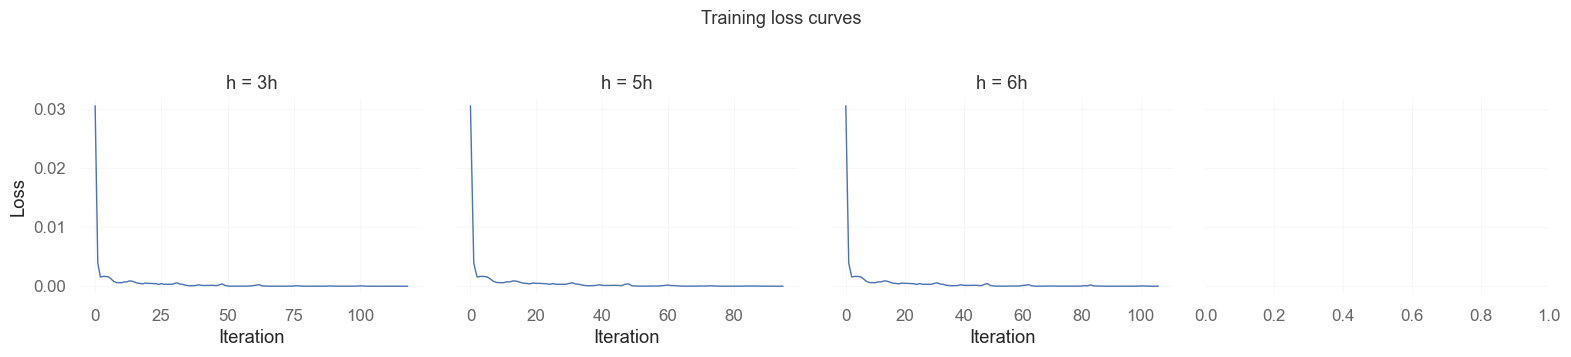

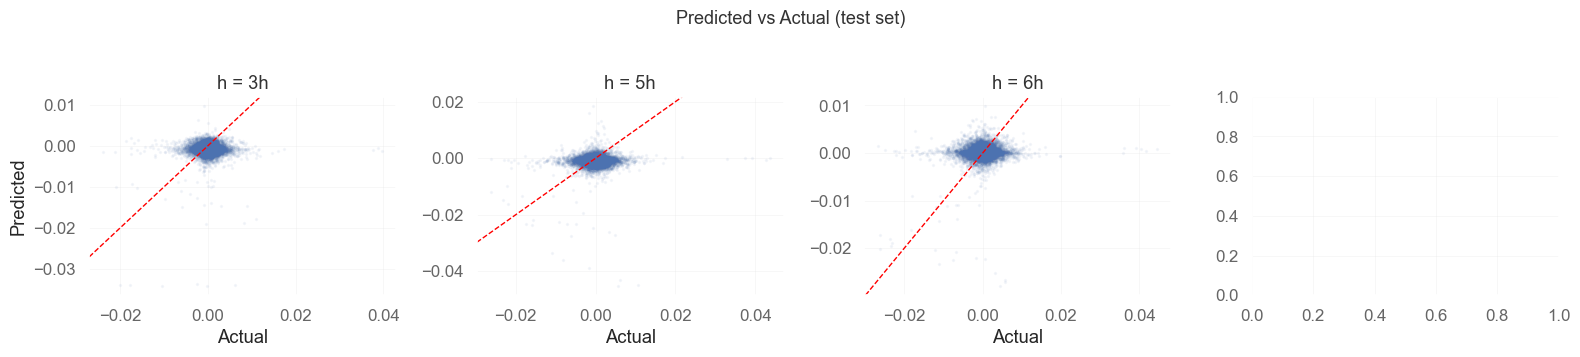

In [101]:
# ---- Train one MLP per horizon ----
mlp_models = {}
results_rows = []

for name, h in HORIZONS.items():
    y_tr_h = y_targets[name][:split]
    y_te_h = y_targets[name][split:]

    mlp = MLPRegressor(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=15,
        random_state=42,
    )
    mlp.fit(X_tr_s, y_tr_h)
    mlp_models[name] = mlp

    pred_te = mlp.predict(X_te_s)
    r2  = r2_score(y_te_h, pred_te)
    mse = mean_squared_error(y_te_h, pred_te)
    directional_acc = np.mean(np.sign(pred_te) == np.sign(y_te_h))
    n_params = sum(c.size for c in mlp.coefs_) + sum(b.size for b in mlp.intercepts_)

    results_rows.append({
        'Horizon': name,
        'R² (test)': r2,
        'MSE (test)': mse,
        'Dir. Accuracy': directional_acc,
        'Params': n_params,
        'Iters': mlp.n_iter_,
    })
    print(f"  {name:>4s} (h={h:>2d}):  R²={r2:+.6f}   DirAcc={directional_acc:.3f}   iters={mlp.n_iter_}")

print("\n" + "=" * 70)
print("Per-horizon MLP comparison  (out-of-sample)")
print("=" * 70)
display(pd.DataFrame(results_rows).set_index('Horizon'))

# ---- Training loss curves ----
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
for ax, (name, mlp) in zip(axes, mlp_models.items()):
    ax.plot(mlp.loss_curve_, lw=1)
    ax.set_title(f'h = {name}')
    ax.set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
plt.suptitle('Training loss curves', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# ---- Scatter: predicted vs actual for each horizon ----
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
for ax, (name, mlp) in zip(axes, mlp_models.items()):
    y_te_h = y_targets[name][split:]
    pred   = mlp.predict(X_te_s)
    ax.scatter(y_te_h, pred, alpha=0.05, s=2, rasterized=True)
    ax.axline((0, 0), slope=1, color='red', lw=1, ls='--')
    ax.set_title(f'h = {name}')
    ax.set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
plt.suptitle('Predicted vs Actual (test set)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

Convergence signals on test set (9,894 bars):
  Long  entries : 643
  Short entries : 981
  Time in market: 28.4%



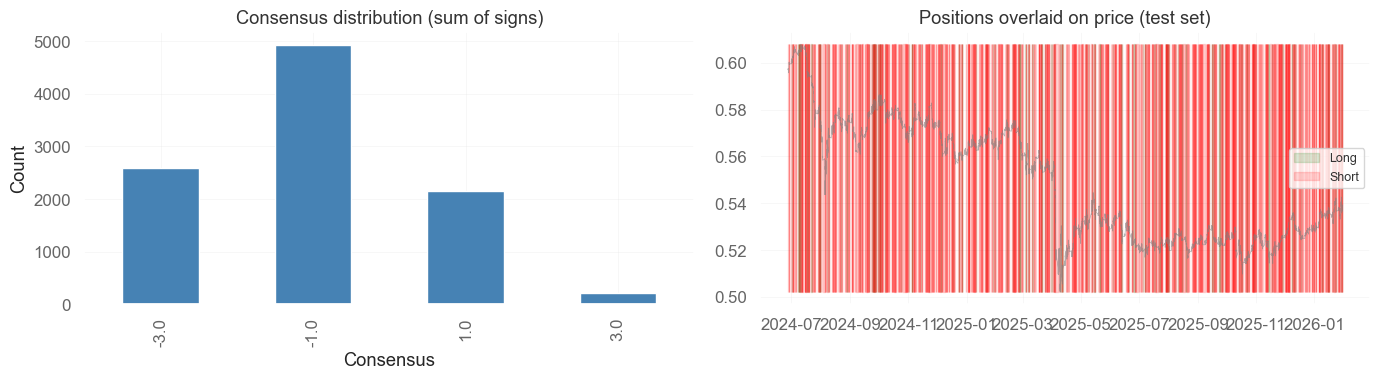

In [102]:
import vectorbt as vbt

# ---- Build convergence signal on test set ----
pred_signs = pd.DataFrame({
    name: np.sign(mlp.predict(X_te_s))
    for name, mlp in mlp_models.items()
}, index=X_te.index)

consensus = pred_signs.sum(axis=1)          # ranges from -4 to +4

# Position: +1 long, -1 short, 0 flat — only when ALL 4 agree
position = pd.Series(0, index=X_te.index)
position[consensus ==  3] =  1.0
position[consensus == -3] = -1.0

# Derive entry / exit signals from position changes
short_exits  = (position ==  1) & (position.shift(1) !=  1)
short_entries    = (position == -1) & (position.shift(1) != -1)
# short_entries = (position == -1) & (position.shift(1) != -1)
# short_exits   = (position != -1) & (position.shift(1) == -1)

close_test = close.reindex(X_te.index)

# ---- Signal diagnostics ----
n_long  = long_entries.sum()
# n_short = short_entries.sum()
pct_in  = (position != 0).mean() * 100
print(f"Convergence signals on test set ({len(X_te):,} bars):")
print(f"  Long  entries : {n_long}")
print(f"  Short entries : {n_short}")
print(f"  Time in market: {pct_in:.1f}%")
print()

# ---- Consensus distribution ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

consensus.value_counts().sort_index().plot.bar(ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Consensus distribution (sum of signs)')
axes[0].set_xlabel('Consensus')
axes[0].set_ylabel('Count')

axes[1].plot(close_test.index, close_test.values, lw=0.5, color='grey', alpha=0.6)
long_mask  = position ==  1
short_mask = position == -1
axes[1].fill_between(close_test.index, close_test.min(), close_test.max(),
                     where=long_mask,  alpha=0.15, color='green', label='Long')
axes[1].fill_between(close_test.index, close_test.min(), close_test.max(),
                     where=short_mask, alpha=0.15, color='red',   label='Short')
axes[1].set_title('Positions overlaid on price (test set)')
axes[1].legend(fontsize=9)
plt.tight_layout()
plt.show()

Vectorbt Backtest  —  AUDCHF H1  (convergence of 4 horizons)
Start                               2024-06-27 13:00:00
End                                 2026-01-30 17:00:00
Period                                412 days 06:00:00
Start Value                                     10000.0
End Value                                   9978.760596
Total Return [%]                              -0.212394
Benchmark Return [%]                          -9.715969
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              11.737558
Max Drawdown Duration                 210 days 10:00:00
Total Trades                                        126
Total Closed Trades                                 125
Total Open Trades                                     1
Open Trade PnL                               -29.400742
Win Rate [%]                                       48.0
Best Trade [%]                             

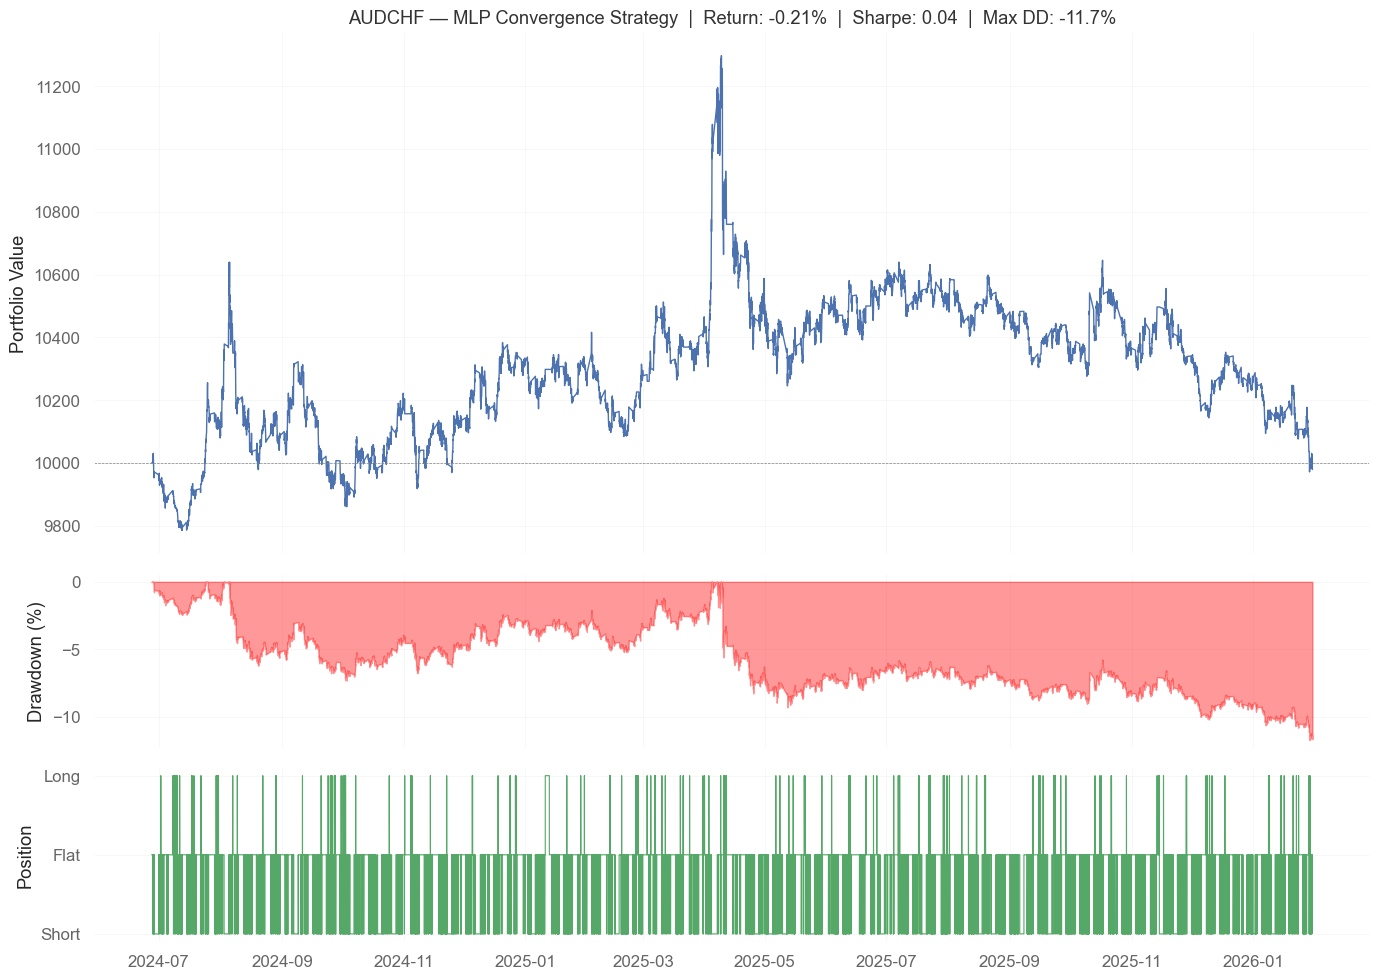


Total trades: 126

Last 10 trades:


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
116,116,0,19680.058079,2025-12-17 21:00:00,0.52520,0.0,2026-01-08 17:00:00,0.53487,0.0,-190.306162,-0.018412,Short,Closed,116
117,117,0,18964.205577,2026-01-08 20:00:00,0.53499,0.0,2026-01-09 04:00:00,0.53508,0.0,-1.706779,-0.000168,Short,Closed,117
118,118,0,18948.972714,2026-01-09 07:00:00,0.53533,0.0,2026-01-14 23:00:00,0.53412,0.0,22.928257,0.002260,Short,Closed,118
119,119,0,18957.452583,2026-01-15 10:00:00,0.53630,0.0,2026-01-16 13:00:00,0.53722,0.0,-17.440856,-0.001715,Short,Closed,119
120,120,0,18917.524303,2026-01-16 15:00:00,0.53651,0.0,2026-01-21 01:00:00,0.53144,0.0,95.911848,0.009450,Short,Closed,120
121,121,0,19232.514524,2026-01-21 07:00:00,0.53271,0.0,2026-01-22 17:00:00,0.53960,0.0,-132.512025,-0.012934,Short,Closed,121
122,122,0,18715.006268,2026-01-22 20:00:00,0.54036,0.0,2026-01-23 19:00:00,0.54068,0.0,-5.988802,-0.000592,Short,Closed,122
123,123,0,18822.705996,2026-01-26 00:00:00,0.53695,0.0,2026-01-28 23:00:00,0.54069,0.0,-70.396920,-0.006965,Short,Closed,123
124,124,0,18614.294047,2026-01-29 03:00:00,0.53918,0.0,2026-01-29 13:00:00,0.54070,0.0,-28.293727,-0.002819,Short,Closed,124
125,125,0,18608.064364,2026-01-29 18:00:00,0.53784,0.0,2026-01-30 17:00:00,0.53942,0.0,-29.400742,-0.002938,Short,Open,125


In [103]:
# ---- Vectorbt Portfolio backtest ----
pf = vbt.Portfolio.from_signals(
    close=close_test,
    # entries=long_entries,
    # exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    freq='1h',
    init_cash=10_000,
    # fees=0.00005,           # ~0.5 pip spread cost for FX
    # slippage=0.00002,
)

print("=" * 70)
print(f"Vectorbt Backtest  —  {SYMBOL} H1  (convergence of 4 horizons)")
print("=" * 70)
print(pf.stats())

# ---- Equity curve + drawdown ----
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                         gridspec_kw={'height_ratios': [3, 1, 1]})

# Equity
equity = pf.value()
axes[0].plot(equity.index, equity.values, lw=1, color='C0')
axes[0].axhline(10_000, color='grey', ls='--', lw=0.5)
axes[0].set_ylabel('Portfolio Value')
axes[0].set_title(f'{SYMBOL} — MLP Convergence Strategy  |  '
                   f'Return: {pf.total_return()*100:.2f}%  |  '
                   f'Sharpe: {pf.sharpe_ratio():.2f}  |  '
                   f'Max DD: {pf.max_drawdown()*100:.1f}%')

# Drawdown
dd = pf.drawdown() * 100
axes[1].fill_between(dd.index, dd.values, 0, alpha=0.4, color='red')
axes[1].set_ylabel('Drawdown (%)')

# Position
axes[2].plot(position.index, position.values, lw=0.8, color='C2', drawstyle='steps-post')
axes[2].set_ylabel('Position')
axes[2].set_yticks([-1, 0, 1])
axes[2].set_yticklabels(['Short', 'Flat', 'Long'])

plt.tight_layout()
plt.show()

# ---- Trade analysis ----
trades = pf.trades.records_readable
if len(trades) > 0:
    print(f"\nTotal trades: {len(trades)}")
    # print(f"Avg trade duration: {trades['Duration'].mean()}")
    print(f"\nLast 10 trades:")
    display(trades.tail(10))

In [98]:
pf.plot_cum_returns()

FigureWidget({
    'data': [{'line': {'color': '#7f7f7f'},
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': '100041b2-5860-412c-bdbe-a57cb20be03d',
              'x': array([datetime.datetime(2024, 6, 27, 13, 0),
                          datetime.datetime(2024, 6, 27, 14, 0),
                          datetime.datetime(2024, 6, 27, 15, 0), ...,
                          datetime.datetime(2026, 1, 30, 15, 0),
                          datetime.datetime(2026, 1, 30, 16, 0),
                          datetime.datetime(2026, 1, 30, 17, 0)], dtype=object),
              'y': array([1.        , 0.99986461, 1.00055198, ..., 0.95390448, 0.95330042,
                          0.95400862])},
             {'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width': 0},
              'opacity': 0,
              'showlegend': False,
              'type': 'scatter',
              'uid': '8f7e9df6-02c0-4b2

---
## 6. Multi-Timeframe Study

Run all four models across M5, M15, H1, H4, D1 and compare p-values and AIC.

In [ ]:
TIMEFRAMES = {
    'M5':  mt5.TIMEFRAME_M5,
    'M15': mt5.TIMEFRAME_M15,
    'H1':  mt5.TIMEFRAME_H1,
    'H4':  mt5.TIMEFRAME_H4,
    'D1':  mt5.TIMEFRAME_D1,
}


def run_all_models(symbol, timeframe, num_bars=50_000, rolling_window=500):
    """Fit the 4 OU variants with rolling z-score and return summary dicts."""
    close     = pull_close_prices(symbol, timeframe, num_bars)
    log_close = np.log(close)

    r_mu    = log_close.rolling(rolling_window).mean()
    r_sigma = log_close.rolling(rolling_window).std()
    X       = ((log_close - r_mu) / r_sigma).dropna()

    dX    = X.diff().dropna()
    X_lag = X.shift(1).dropna()

    results = {}

    # 1) Classic
    m = sm.OLS(dX, sm.add_constant(X_lag)).fit()
    b = m.params.iloc[1]
    results['Classic'] = dict(
        R2=m.rsquared, AIC=m.aic, BIC=m.bic,
        b=b, b_pval=m.pvalues.iloc[1],
        half_life=-np.log(2) / np.log(1 + b) if b < 0 else np.nan,
    )

    # 2) Tanh — profile-optimise alpha
    def _aic(alpha):
        return sm.OLS(dX, sm.add_constant(np.tanh(alpha * X_lag))).fit().aic

    opt = minimize_scalar(_aic, bounds=(0.05, 15.0), method='bounded')
    alpha = opt.x
    m = sm.OLS(dX, sm.add_constant(np.tanh(alpha * X_lag))).fit()
    results['Tanh'] = dict(
        R2=m.rsquared, AIC=m.aic, BIC=m.bic,
        b=m.params.iloc[1], b_pval=m.pvalues.iloc[1],
        alpha=alpha,
    )

    # 3) Asymmetric
    feats = pd.DataFrame({'X_pos': X_lag.clip(lower=0),
                          'X_neg': X_lag.clip(upper=0)}, index=X_lag.index)
    m = sm.OLS(dX, sm.add_constant(feats)).fit()
    results['Asymmetric'] = dict(
        R2=m.rsquared, AIC=m.aic, BIC=m.bic,
        b_pos=m.params['X_pos'], b_pos_pval=m.pvalues['X_pos'],
        b_neg=m.params['X_neg'], b_neg_pval=m.pvalues['X_neg'],
    )

    # 4) Asymmetric Tanh (reuse optimal alpha)
    tanh_f = np.tanh(alpha * X_lag)
    feats = pd.DataFrame({'tanh_pos': tanh_f.clip(lower=0),
                          'tanh_neg': tanh_f.clip(upper=0)}, index=X_lag.index)
    m = sm.OLS(dX, sm.add_constant(feats)).fit()
    results['Asym. Tanh'] = dict(
        R2=m.rsquared, AIC=m.aic, BIC=m.bic,
        b_pos=m.params['tanh_pos'], b_pos_pval=m.pvalues['tanh_pos'],
        b_neg=m.params['tanh_neg'], b_neg_pval=m.pvalues['tanh_neg'],
        alpha=alpha,
    )

    return results, len(X)

In [ ]:
print(f"Running {SYMBOL} across timeframes  (rolling_window={ROLLING_WINDOW}) ...\n")

all_results = {}
for tf_name, tf_val in TIMEFRAMES.items():
    try:
        res, n = run_all_models(SYMBOL, tf_val, NUM_BARS, ROLLING_WINDOW)
        all_results[tf_name] = res
        print(f"  {tf_name:>4s}:  {n:>6,} obs  OK")
    except Exception as e:
        print(f"  {tf_name:>4s}:  FAILED  —  {e}")

# ---- Display per-timeframe results ----
for tf_name, res in all_results.items():
    print(f"\n{'=' * 60}")
    print(f"  {SYMBOL}  —  {tf_name}")
    print(f"{'=' * 60}")
    display(pd.DataFrame(res).T.fillna(''))

In [ ]:
# ---- Summary: best AIC per timeframe ----
rows = []
for tf_name, res in all_results.items():
    for model_name, metrics in res.items():
        rows.append({'Timeframe': tf_name, 'Model': model_name, 'AIC': metrics['AIC'], 'R2': metrics['R2']})

summary_df = pd.DataFrame(rows)
best_aic = summary_df.loc[summary_df.groupby('Timeframe')['AIC'].idxmin()]

print("Best model per timeframe (lowest AIC):")
print("=" * 50)
display(best_aic[['Timeframe', 'Model', 'AIC', 'R2']].reset_index(drop=True))

# ---- Plot AIC across timeframes ----
fig, ax = plt.subplots(figsize=(10, 5))
for model_name in ['Classic', 'Tanh', 'Asymmetric', 'Asym. Tanh']:
    subset = summary_df[summary_df['Model'] == model_name]
    ax.plot(subset['Timeframe'], subset['AIC'], 'o-', label=model_name, markersize=6)

ax.set_xlabel('Timeframe')
ax.set_ylabel('AIC (lower is better)')
ax.set_title(f'{SYMBOL} — AIC by Model and Timeframe')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
mt5.shutdown()
print("MT5 connection closed.")